In [56]:
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature
from skimage import measure
import earthpy.plot as ep
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from skimage.filters import threshold_otsu
from shapely import Polygon
from shapely.affinity import affine_transform
import rasterio as rio
from rasterio.plot import reshape_as_image, show
import geopandas as gpd
import pandas as pd

In [2]:
ds = rxr.open_rasterio('output/stacked_BOA.tif')

ds

<xarray.DataArray (band: 11, y: 1370, x: 1049)>
[15808430 values with dtype=float32]
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 3.549e+05 3.549e+05 ... 3.653e+05 3.653e+05
  * y            (y) float64 6.535e+06 6.535e+06 ... 6.522e+06 6.522e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

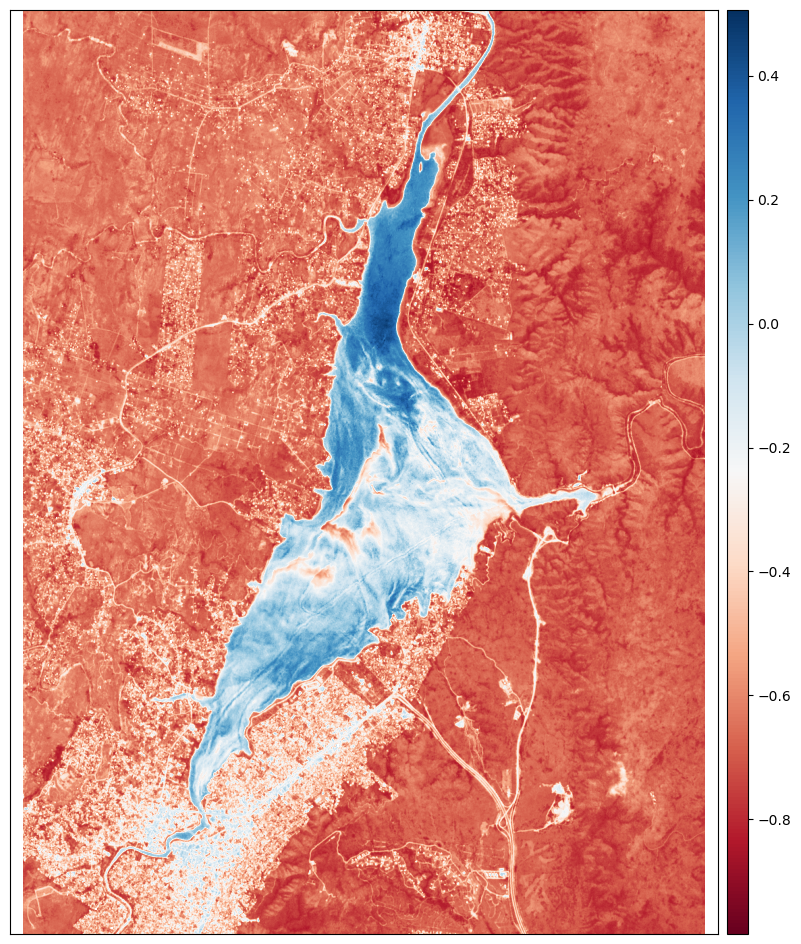

<Axes: >

In [3]:
ndwi = (ds[2] - ds[7]) / (ds[2] + ds[7])

ep.plot_bands(ndwi, cmap = "RdBu")

In [4]:
def edge_detect(image, sigma, high_threshold, low_threshold):
    edges = feature.canny(image, sigma, high_threshold = high_threshold, low_threshold = low_threshold)
    
    plt.imshow(edges)
    
    return plt.show()

In [5]:
interact(
    edge_detect,                 # Method to make interactive (should be a function that returns a plt.show object)
    image=fixed(ndwi),   # Data to pass on db (does not change)
    sigma=(1, 10, 1),        # Range start/end/step of eps
    high_threshold=(0, 0.5, 0.05),
    low_threshold=(0, 0.3, 0.05) # Range start/end/step of min_samples
);

interactive(children=(IntSlider(value=5, description='sigma', max=10, min=1), FloatSlider(value=0.25, descript…

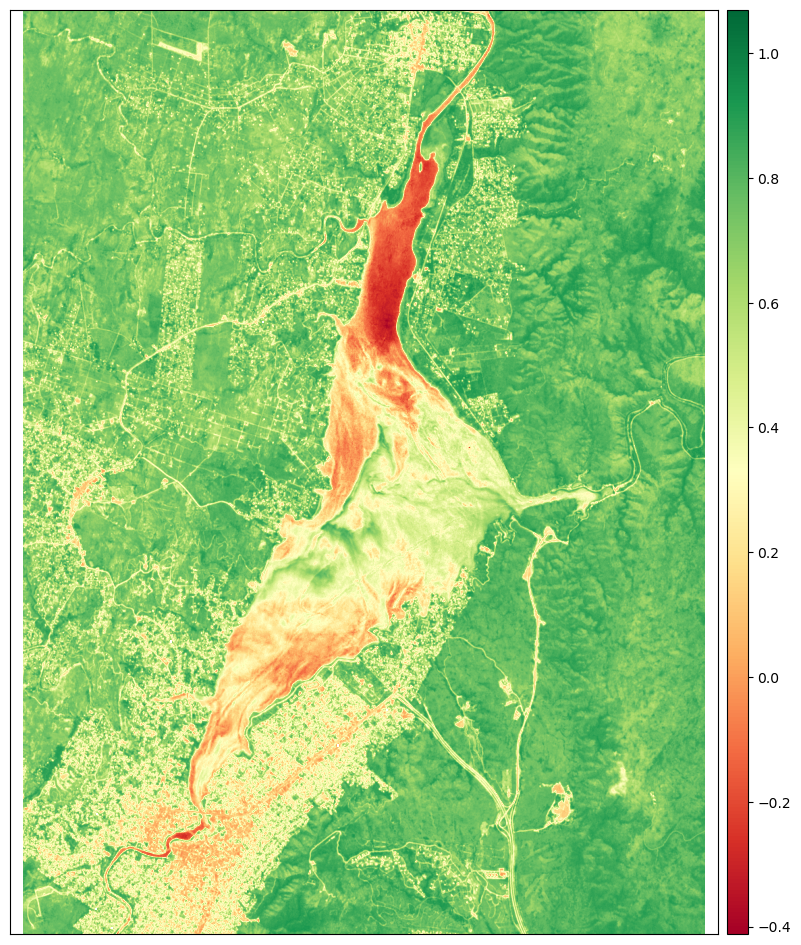

<Axes: >

In [139]:
# Apparently edge detection is not the best way to go about this - the best thing to do is binary thresholding 
# following by contour detection

ndvi = (ds[7] - ds[3]) / (ds[7] + ds[3])

ep.plot_bands(ndvi, cmap = "RdYlGn")

In [140]:
def water_body(ndvi, ndwi, ndvi_thresh, ndwi_thresh):
    image = ds.where((ndvi < ndvi_thresh) & (ndwi > ndwi_thresh), np.nan)
    
    ep.plot_rgb(image.data, rgb = (3,2,1), stretch = True)
    
    return plt.show()

In [141]:
# It doesn't look like there's a particularly good set of thresholds that reveal water

interact(
    water_body,                 # Method to make interactive (should be a function that returns a plt.show object)
    ndwi=fixed(ndwi),   # Data to pass on db (does not change)
    ndvi=fixed(ndvi),
    ndvi_thresh=(-1, 1, 0.1),        # Range start/end/step of eps
    ndwi_thresh=(-1, 1, 0.1) # Range start/end/step of min_samples
);

interactive(children=(FloatSlider(value=0.0, description='ndvi_thresh', max=1.0, min=-1.0), FloatSlider(value=…

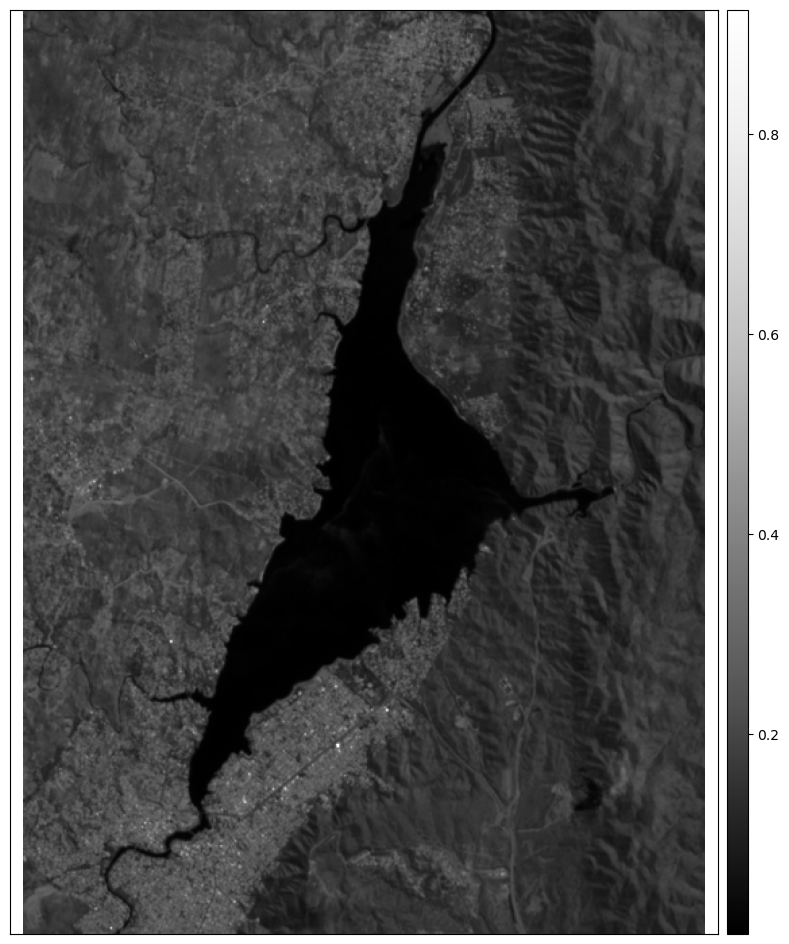

0.1473366

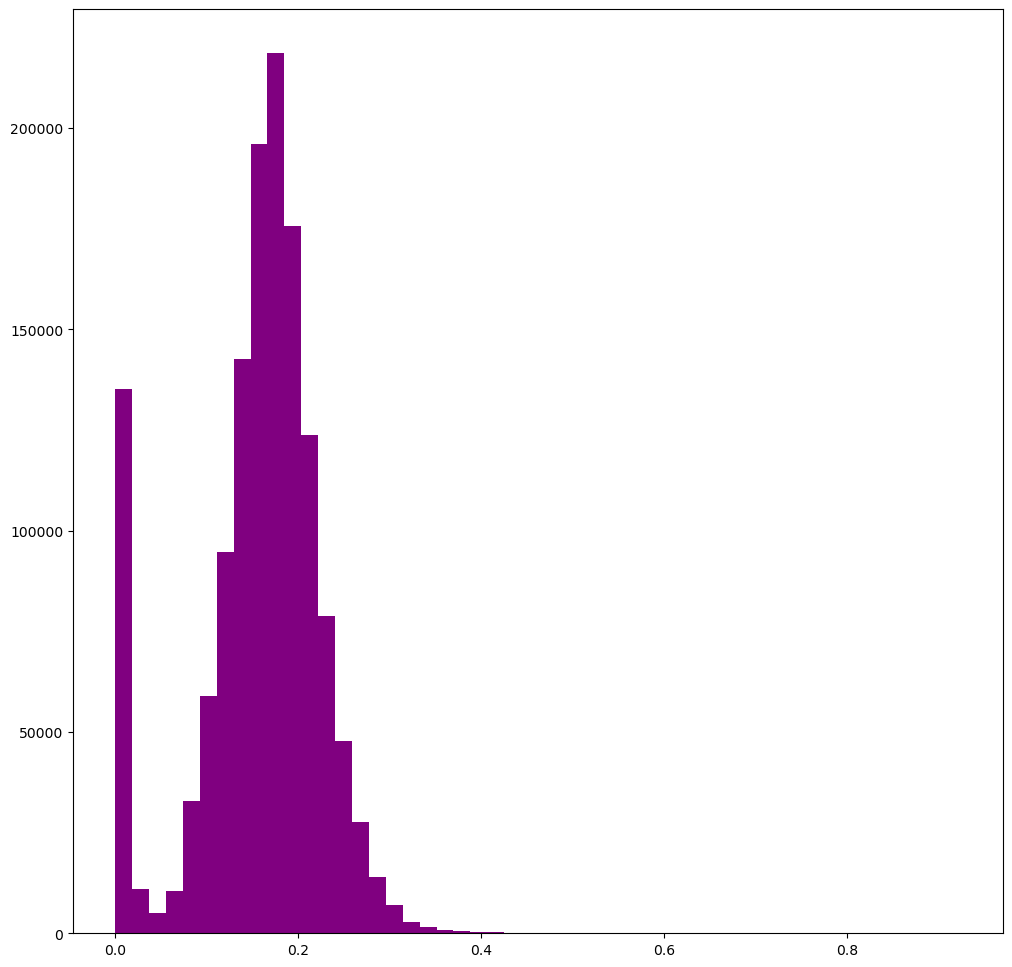

In [9]:
# Try thresholding with band 8A instead.
# Looks like its much better, and much easier too (only one band)
# ep.plot_bands(ds[-3])
# ep.hist(ds[-3].data, bins = 50)

# NOTE: skimage does NOT deal well with np.nans. Use the code below to select all non-nan values.
# Threshold_otsu is an algorithm that finds the best threshold for binary thresholding
threshold = threshold_otsu(ds[-3].data[~np.isnan(ds[-1].data)])

threshold

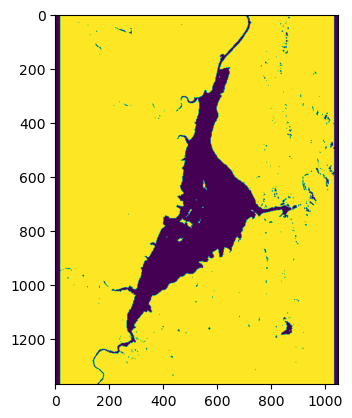

In [10]:
binary = ds[-3].data > threshold

plt.imshow(binary)

In [11]:
contours = measure.find_contours(binary)

# Identify the longest contours - try to use to create polygon
longest = sorted(contours, key = len, reverse = True)[:2]

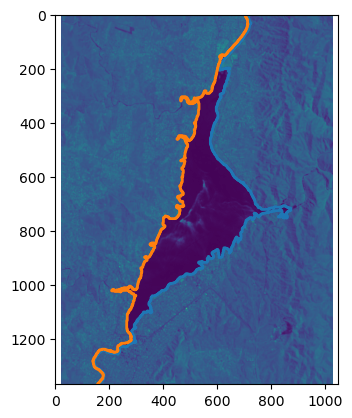

In [12]:
fig, ax = plt.subplots()

ax.imshow(ds[-3])

for contour in longest:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

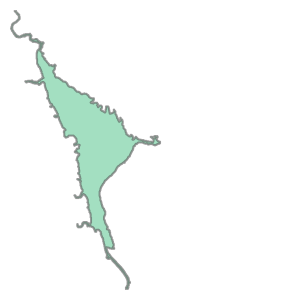

In [142]:
# Combine contours to feed into Polygon
poly_coords = np.vstack([longest[0], longest[1]])

# Weird as hell - skimage contours are returned as y, x values for some reason
# Don't worry about orientation...
roi = Polygon(np.fliplr(poly_coords))

roi

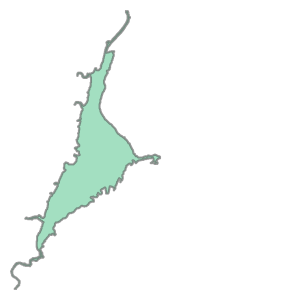

In [143]:
# Prepare matrix from affine
transform = ds.rio.transform()
coef_6_transform = [element for tupl in transform.column_vectors for element in tupl]

# Note that the affine transform georeferences AND fixes the orientation
roi = affine_transform(roi, coef_6_transform)

roi

<Axes: >

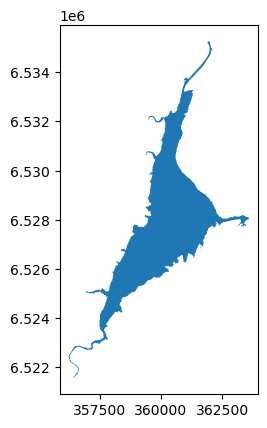

In [18]:
# Create geojson from contour polygon
gdf = gpd.GeoDataFrame(geometry = [roi], crs = ds.rio.crs)

gdf.to_file("lake_polygon.geojson", driver = "GeoJSON")

gdf.plot()

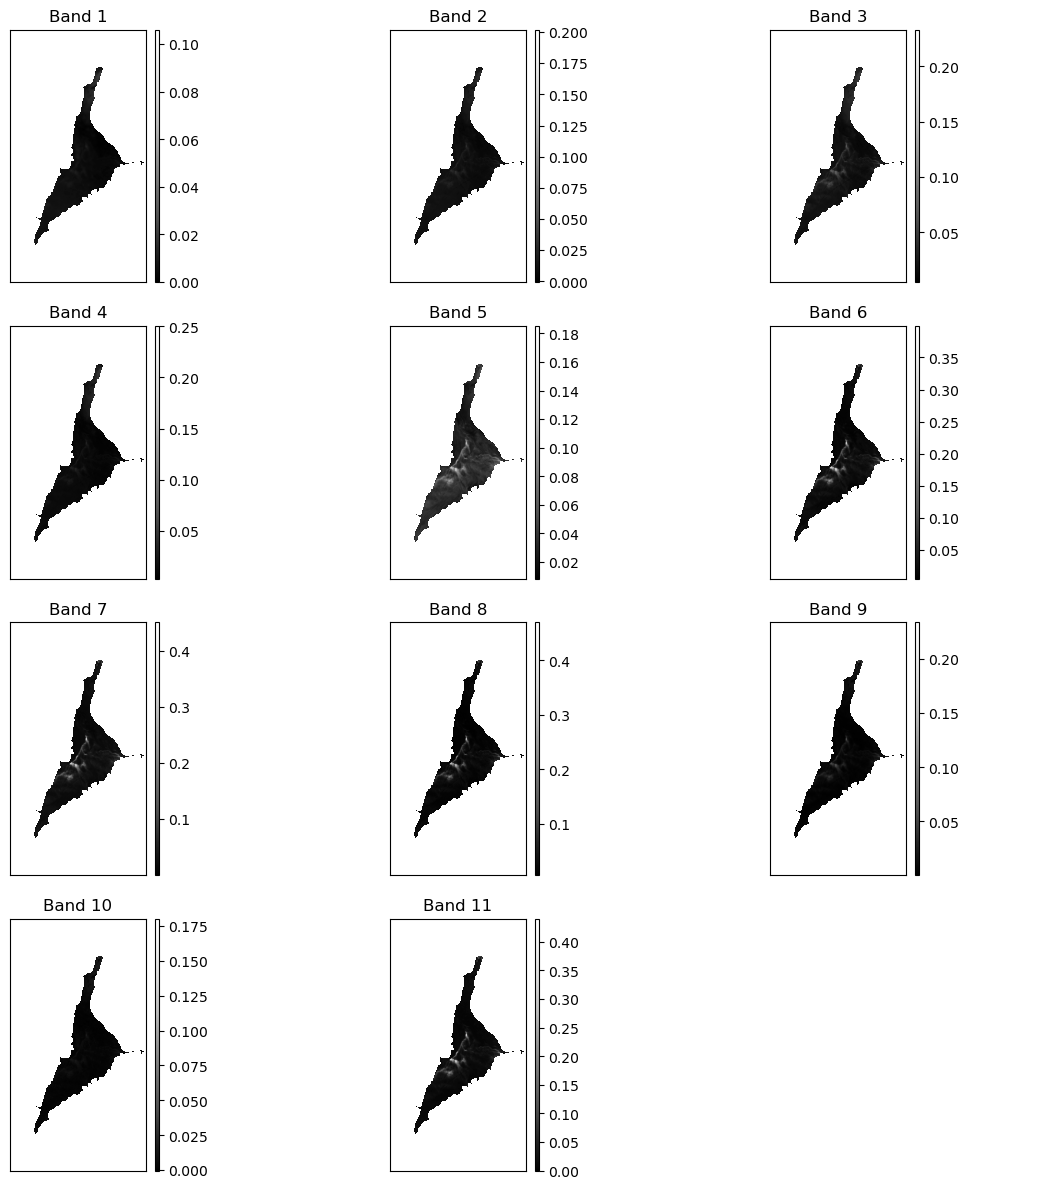

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>,
        <Axes: title={'center': 'Band 8'}>,
        <Axes: title={'center': 'Band 9'}>],
       [<Axes: title={'center': 'Band 10'}>,
        <Axes: title={'center': 'Band 11'}>, <Axes: >]], dtype=object)

In [22]:
clipped = rxr.open_rasterio('output/stacked_BOA.tif').rio.clip(gdf.geometry, from_disk = True)

ep.plot_bands(clipped)

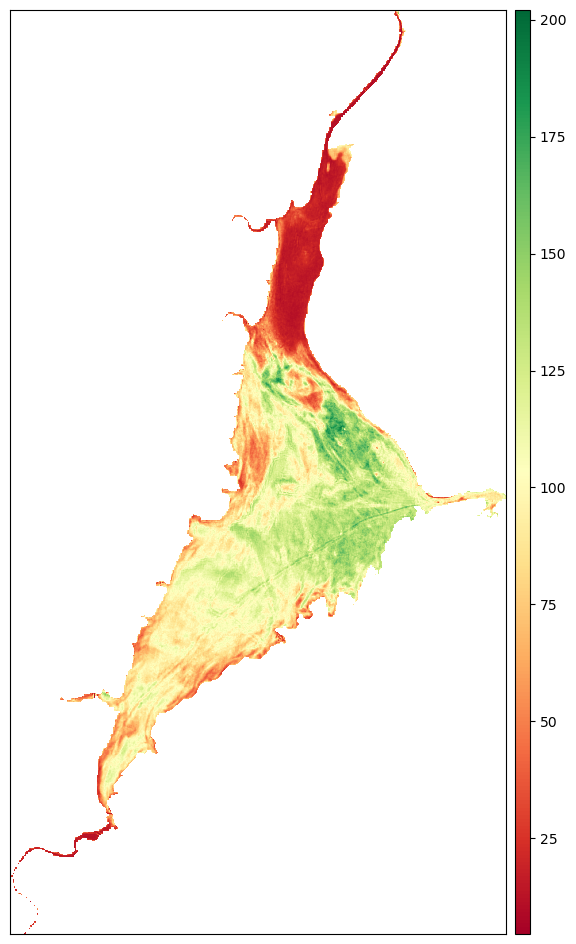

<Axes: >

In [73]:
def norm_diff(band1, band2):
    return (band1 - band2) / (band1 + band2)

# This is the normalized difference chlorophyll index as published by Mishra and Mishra 2012
# Uses bands 4 and 5 to create chlorophyll concentrations in mg/m3 
x = norm_diff(clipped[4], clipped[3])

ndci = 14.039 + 86.115*x + 194.325*x**2

ep.plot_bands(ndci, cmap = "RdYlGn")

In [84]:
# Save the NDCI raster
ndci.rio.write_nodata(np.nan, inplace = True)
ndci.rio.to_raster("output/ndci_20170222.tif")

In [62]:
# Compare with insitu data from 
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8898098

def convert(tude):
    """
    converts latitude/longitude in the form XX-XX-XX.X<N/S> to decimal degrees
    """
    multiplier = 1 if tude[-1] in ['N', 'E'] else -1
    return multiplier * sum(float(x) / 60 ** n for n, x in enumerate(tude[:-1].split('-')))

# Read in data file
df = pd.read_csv("insitu_data.csv")

# Set to decimal degrees
df['lat_deg'] = df["Lat"].apply(lambda x: convert(x))
df['lon_deg'] = df["Lon"].apply(lambda x: convert(x))

# Create geodataframe
gdf = gpd.GeoDataFrame(
    {
        "site": df["Site"],
        "Chl-a 2/22": df["Chl-a 2/22"],
        "Chl-a 11/14": df["Chl-a 11/14"],
        "geometry": gpd.points_from_xy(
            df["lon_deg"], df["lat_deg"]
        )
    }, crs="EPSG:4326"
)

gdf = gdf.to_crs(clipped.rio.crs)

gdf

site  Chl-a 2/22  Chl-a 11/14                        geometry
0    Centro       127.1       221.32  POINT (360276.522 6527867.610)
1    Zona A        53.8       117.48  POINT (361637.929 6528218.304)
2    Zona B       288.5        52.31  POINT (361637.618 6527642.405)
3  Garganta       197.1        69.38  POINT (362879.385 6528049.868)
4     SAT 1        27.6        85.00  POINT (358875.607 6525751.534)
5     SAT 2       132.2        73.42  POINT (359660.290 6527123.318)
6     SAT 3        94.7       341.98  POINT (360861.307 6528996.399)
7     SAT 4        56.7       703.12  POINT (360017.182 6529477.891)

<Axes: >

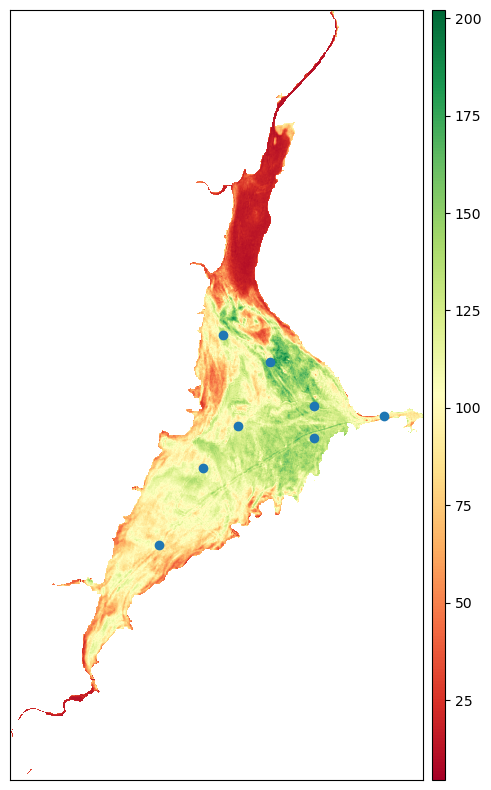

In [81]:
# Get list of coords from gdf
from rasterio.plot import plotting_extent

fig, ax = plt.subplots(figsize = (10,10))

extent = plotting_extent(ndci.squeeze(), transform = ndci.rio.transform())

ep.plot_bands(ndci, ax = ax, extent = extent, cmap = "RdYlGn")
gdf.plot(ax = ax)

In [107]:
sampling_coords = [(x, y) for x,y in zip(gdf.geometry.x, gdf.geometry.y)]

# Grab NDCI values at each point
# Note that .values gives you a scalar ndarray, so you need to call the .item() method to get the actual value
gdf["ndci_values_20170222"] = [ndci.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

# NOTE: This basically does a "dot product" of the x and y values - if you provide 8 x values and 8 y values, you'll get 
# 64 results - we don't want that
# ndci.sel(x = gdf.geometry.x.values, y = gdf.geometry.y.values, method = "nearest")

gdf

site  Chl-a 2/22  Chl-a 11/14                        geometry  \
0    Centro       127.1       221.32  POINT (360276.522 6527867.610)   
1    Zona A        53.8       117.48  POINT (361637.929 6528218.304)   
2    Zona B       288.5        52.31  POINT (361637.618 6527642.405)   
3  Garganta       197.1        69.38  POINT (362879.385 6528049.868)   
4     SAT 1        27.6        85.00  POINT (358875.607 6525751.534)   
5     SAT 2       132.2        73.42  POINT (359660.290 6527123.318)   
6     SAT 3        94.7       341.98  POINT (360861.307 6528996.399)   
7     SAT 4        56.7       703.12  POINT (360017.182 6529477.891)   

   ndci_values_20170222  
0            111.139557  
1            123.920883  
2            141.046982  
3             87.300995  
4             87.832832  
5            104.046021  
6            141.598984  
7            151.685669

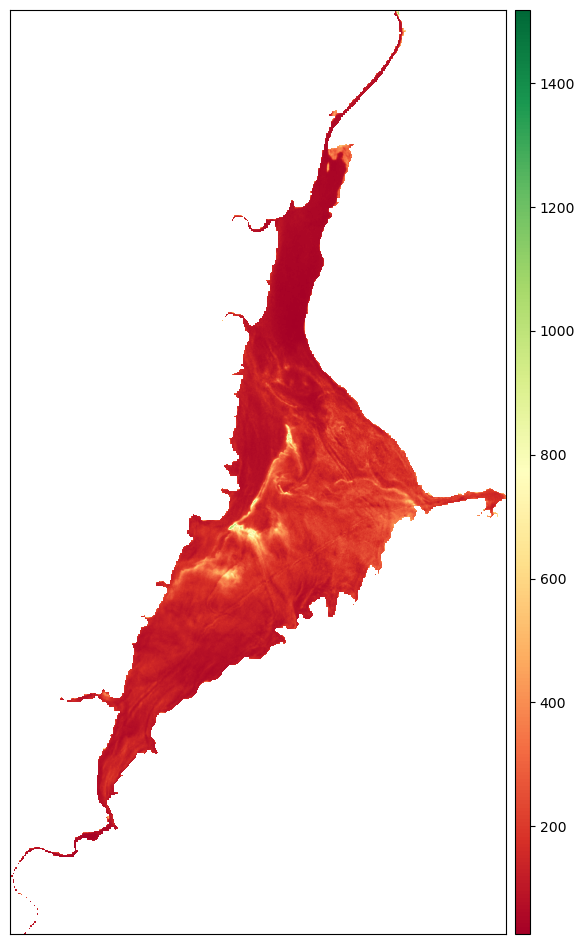

<Axes: >

In [119]:
# Algorithm used by Cordoba University
# 
san_roque = (clipped[7] / clipped[3])*80.748 - 8.024

ep.plot_bands(san_roque, cmap = "RdYlGn")

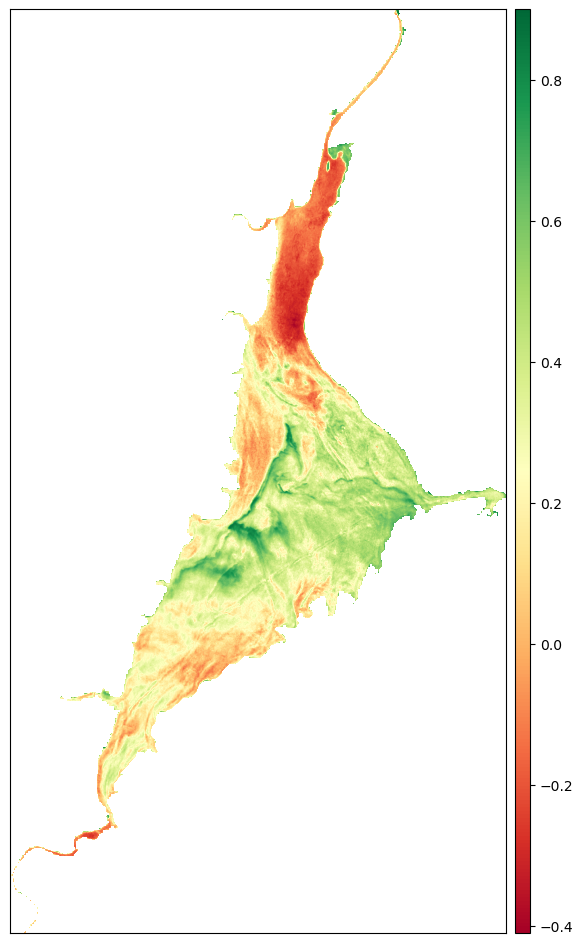

In [146]:
ndvi_clipped = norm_diff(clipped[7], clipped[3])

ep.plot_bands(ndvi_clipped, cmap = "RdYlGn")

ndvi_metric = [ndvi_clipped.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

# ratio = clipped[7] / clipped[3]

# [ratio.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

Slope: 378.8926376588416
Intercept: -16.13862963569352
Correlation coefficient: 0.5569919376448502
P-value: 0.15153791174081516
Standard error of the slope: 230.64318639474453


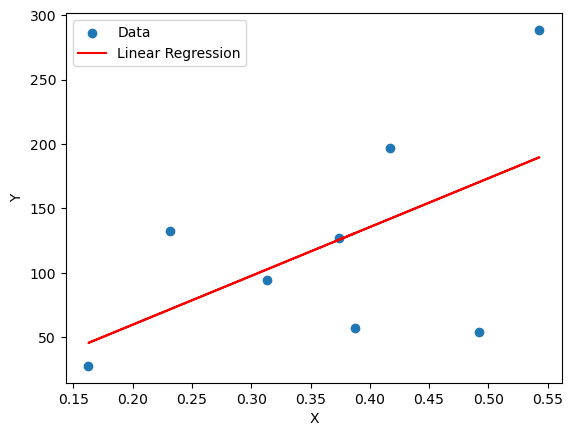

In [152]:
from scipy.stats import linregress

y = gdf["Chl-a 2/22"]
x = ndvi_metric

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Print the results
print("Slope:", slope)
print("Intercept:", intercept)
print("Correlation coefficient:", r_value)
print("P-value:", p_value)
print("Standard error of the slope:", std_err)

# Plot the data and the regression line
plt.scatter(x, y, label='Data')
plt.plot(x, intercept + slope * np.array(x), color='red', label='Linear Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [153]:
ndvi_algo = ndvi_clipped * 378.89 - 16.13

gdf["ndvi_algo_values_20170222"] = [ndvi_algo.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

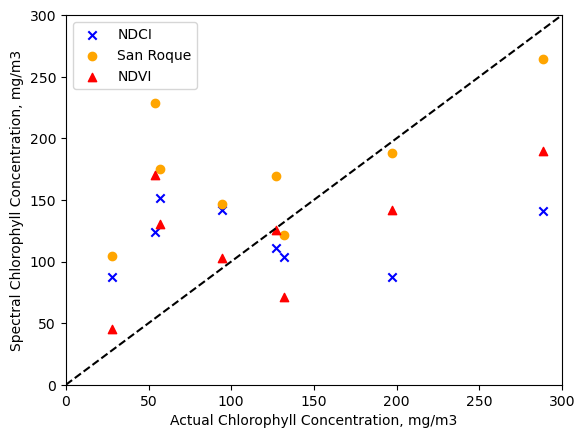

In [156]:
fig, ax = plt.subplots()

ax.scatter(gdf["Chl-a 2/22"], gdf["ndci_values_20170222"], label = "NDCI", c = "b", marker = "x")
ax.scatter(gdf["Chl-a 2/22"], gdf["san_roque_values_20170222"], label = "San Roque", c = "orange")
ax.scatter(gdf["Chl-a 2/22"], gdf["ndvi_algo_values_20170222"], label = "NDVI", c = "r", marker = "^")
ax.plot([0,300], [0,300], c = "k", linestyle = "--")
ax.set_xlabel("Actual Chlorophyll Concentration, mg/m3")
ax.set_ylabel("Spectral Chlorophyll Concentration, mg/m3")
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
ax.legend()

In [ ]:
gdf["san_roque_values_20170222"] = [san_roque.sel(x = x, y = y, method = "nearest").values.item() for x, y in sampling_coords]

gdf

In [157]:
# Compute errors between each value
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

metrics = list()

for dataset in ["ndci_values_20170222", "san_roque_values_20170222", "ndvi_algo_values_20170222"]: 
    
    y_test = gdf["Chl-a 2/22"]
    y_pred = gdf[dataset]
    
    mse = mean_squared_error(y_test, y_pred)

    rmse = np.sqrt(mse)

    mae = mean_absolute_error(y_test, y_pred)

    rsquared = r2_score(y_test, y_pred)

    max_error_value = max_error(y_test, y_pred)
    
    metrics.append([mse, rmse, mae, rsquared, max_error_value])

metrics_df = pd.DataFrame(metrics, columns = ["mse", "rmse", "mae", "rsquared", "max_error"], index = ["NDCI", "San Roque Algo", "NDVI"]).T

# Looks like both are really shit lmao
metrics_df

NDCI  San Roque Algo         NDVI
mse        6826.540092     6968.633094  4488.951789
rmse         82.622879       83.478339    66.999640
mae          71.700602       63.422375    54.031310
rsquared     -0.048947       -0.070781     0.310240
max_error   147.453018      175.241260   116.428012

In [158]:
gdf

site  Chl-a 2/22  Chl-a 11/14                        geometry  \
0    Centro       127.1       221.32  POINT (360276.522 6527867.610)   
1    Zona A        53.8       117.48  POINT (361637.929 6528218.304)   
2    Zona B       288.5        52.31  POINT (361637.618 6527642.405)   
3  Garganta       197.1        69.38  POINT (362879.385 6528049.868)   
4     SAT 1        27.6        85.00  POINT (358875.607 6525751.534)   
5     SAT 2       132.2        73.42  POINT (359660.290 6527123.318)   
6     SAT 3        94.7       341.98  POINT (360861.307 6528996.399)   
7     SAT 4        56.7       703.12  POINT (360017.182 6529477.891)   

   ndci_values_20170222  san_roque_values_20170222  ndvi_algo_values_20170222  
0            111.139557                 169.347412                 125.702217  
1            123.920883                 229.041260                 170.228012  
2            141.046982                 264.610199                 189.606903  
3             87.300995                 188.273788                 141.896805  
4             87.832832                 104.094315                  45.497658  
5            104.046021                 121.384323                  71.599510  
6            141.598984                 146.384659                 102.553810  
7            151.685669                 174.879669                 130.676437

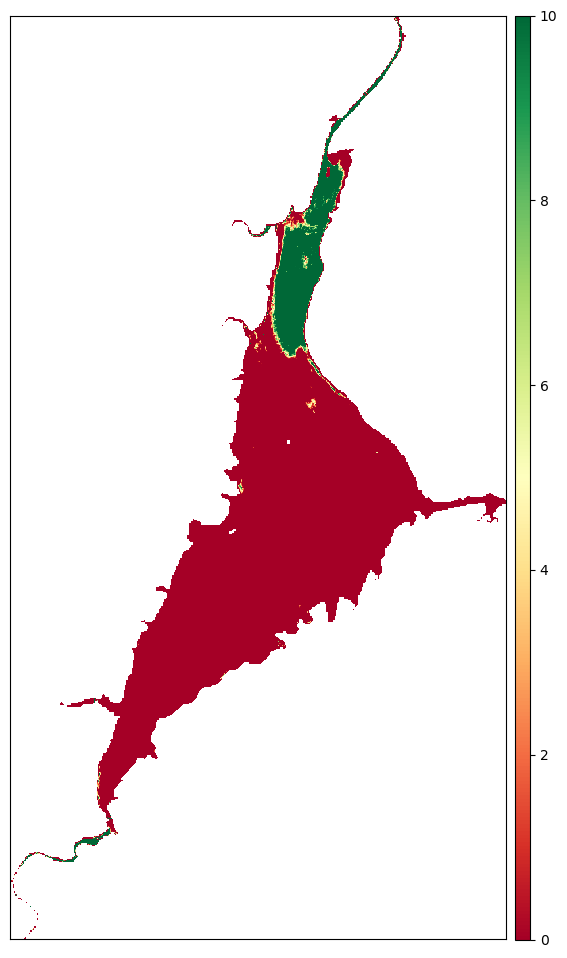

<Axes: >

In [55]:
# # Alternative chlorophyll detection algorithm is by Gons et al. 2005
# # bands 1 2 3 = Sentinel band 4 5 7, respectively
# # sigma is the absoprtion at wavelength 664nm due to phytoplakton, which differs between species and should be calibrated.
# # Default is 0.015
# # For some reason Gons straight up does not apply well to this dataset. Unsure why

# def gons_chloro(band4, band5, band7, sigma = 0.015):
    
#     b = (1.61 * band7) / ((0.082 - 0.6 * band7))
#     C = ((band4 / band5) * (0.7 + b) - 0.4 - b**1.06) / sigma
    
#     return b, C

# b, gons = gons_chloro(clipped[3], clipped[4], clipped[6])

# ep.plot_bands(gons, cmap = "RdYlGn", vmin = 0, vmax = 10)

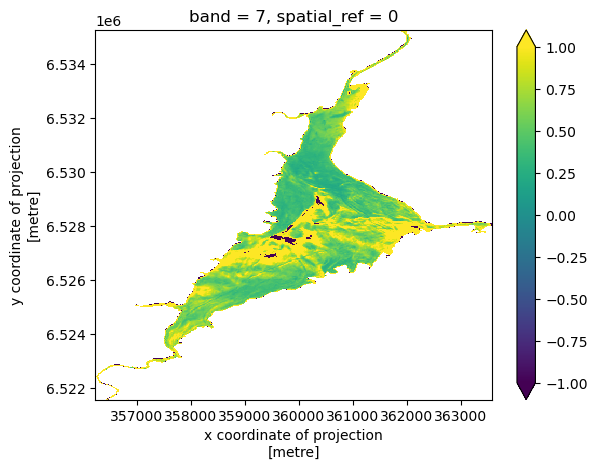

In [36]:
# b.plot(vmin = -1, vmax = 1)

In [31]:
# def gons_map(image, sigma):
#     gons = gons_chloro(image[3], image[4], image[6], sigma)

#     ep.plot_bands(gons, cmap = "RdYlGn")
    
#     return plt.show()
    

# interact(
#     gons_map,                 # Method to make interactive (should be a function that returns a plt.show object)
#     image=fixed(clipped),   # Data to pass on db (does not change)
#     sigma=(0, 1, 0.05) # Range start/end/step of min_samples
# );

interactive(children=(FloatSlider(value=0.0, description='sigma', max=1.0, step=0.05), Output()), _dom_classes…

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\earthpy\spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


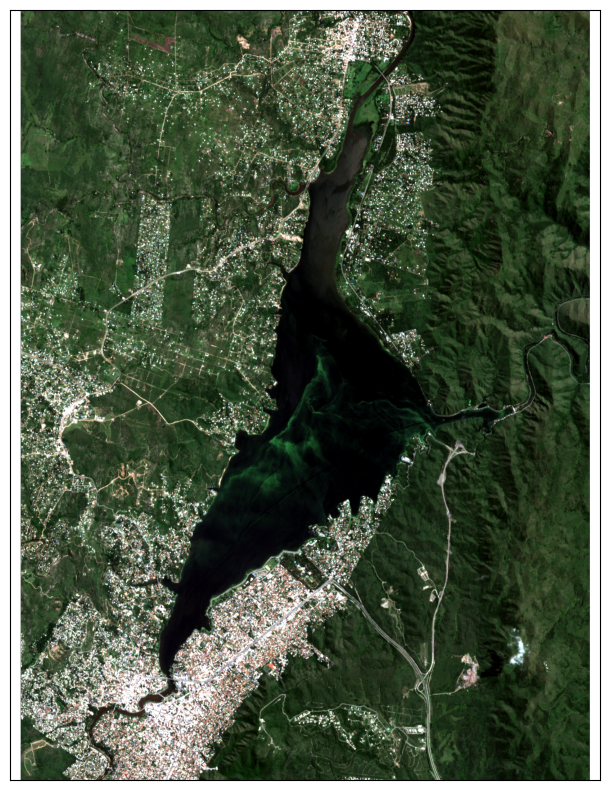

<Axes: >

In [27]:
ep.plot_rgb(ds.data, rgb = (3,2,1), stretch = True)

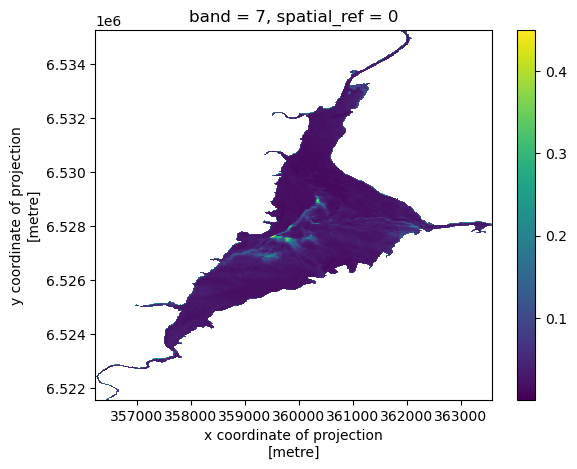

In [40]:
clipped[6].plot()